<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_16_ensemble_040_baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sklearn
print(sklearn.__version__)

1.3.2


Improving a machine learning model involves several steps, and doing it in an optimal order can save time and effort. Here's a structured approach to model improvement:

### Step-by-Step Approach to Model Improvement

1. **Baseline Model**:
   - Start with a simple model (Logistic Regression in your case) to establish a baseline performance. Evaluate it thoroughly.
   - **Goal**: Understand current model performance and identify weaknesses.

2. **Feature Engineering**:
   - Explore additional feature engineering to create new informative features or transform existing ones.
   - **Goal**: Improve the quality of input features.

3. **Handle Class Imbalance**:
   - Apply resampling techniques (e.g., SMOTE, ADASYN, RandomUnderSampler) to handle class imbalance.
   - **Goal**: Ensure the model is trained on a balanced dataset, improving its ability to predict minority classes.
   
4. **Model Selection**:
   - Try different models (Random Forest, HistGradientBoostingClassifier, LGBMClassifier) to find the best performing model.
   - **Goal**: Identify a model that has the potential to perform better than the baseline.

5. **Hyperparameter Tuning**:
   - Use GridSearchCV or RandomizedSearchCV to fine-tune hyperparameters of the chosen models.
   - **Goal**: Optimize model parameters for better performance.

6. **Threshold Tuning**:
   - Adjust the decision threshold to optimize for specific metrics (e.g., recall for the minority class, F1 score).
   - **Goal**: Tailor the model's decision-making to align with your business objectives.

7. **Ensemble Methods**:
   - Combine multiple models using techniques like VotingClassifier to leverage the strengths of different models.
   - **Goal**: Improve overall model performance by combining predictions from multiple models.

8. **Cross-Validation**:
   - Perform cross-validation to evaluate the stability and robustness of the model.
   - **Goal**: Ensure the model generalizes well to unseen data.

9. **Model Evaluation and Comparison**:
   - Compare the performance of all models and configurations using the evaluation metrics (recall, precision, F1 score, etc.).
   - **Goal**: Identify the best model configuration.

10. **Final Model Training**:
    - Train the final model on the entire training dataset.
    - **Goal**: Maximize the amount of data the final model is trained on.



In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report, make_scorer
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from loan_data_utils import load_and_preprocess_data, evaluate_model, compile_metrics
import joblib
import json
import logging
import matplotlib.pyplot as plt
import seaborn as sns
# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load and preprocess data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Assuming the `load_and_preprocess_data` function is defined elsewhere
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

### Baseline Logistic Regression Model

In [4]:
# Define the pipeline with logistic regression as the classifier
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Save the model
joblib.dump(pipeline, 'logistic_regression_baseline_model.pkl')

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.69      0.24      0.36      1327

    accuracy                           0.81      6000
   macro avg       0.76      0.61      0.62      6000
weighted avg       0.79      0.81      0.77      6000



['logistic_regression_baseline_model.pkl']

### Evaluate Multiple Models

In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib
import logging
from loan_data_utils import load_and_preprocess_data, evaluate_model, compile_metrics, plot_report

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Define your URL, categorical columns, and target
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

# List to store metrics for each model
metrics_list = []

# Define the models to evaluate with their types
models = {
    'Logistic Regression': ('baseline', LogisticRegression(solver='liblinear', random_state=42)),
    'Random Forest': ('RF', RandomForestClassifier(random_state=42)),
    'HistGradientBoosting': ('baseline', HistGradientBoostingClassifier(random_state=42)),
    'LGBM': ('baseline', LGBMClassifier(random_state=42))
}

# Evaluate each model and capture metrics
for model_name, (model_type, model) in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    metrics = evaluate_model(pipeline, X_train, X_test, y_train, y_test, model_name, model_type)
    metrics_list.append(metrics)

# Compile metrics into a DataFrame, save to CSV
metrics_df = compile_metrics(metrics_list)

# Optionally, save the best performing model
best_model_name = metrics_df.loc[metrics_df['F1_Macro'].idxmax(), 'Model']
best_model_type, best_model = models[best_model_name]

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])

pipeline.fit(X_train, y_train)
joblib.dump(pipeline, f'best_model_{best_model_name}.pkl')
logger.info(f"Best model saved as best_model_{best_model_name}.pkl")

[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221208 -> initscore=-1.258639
[LightGBM] [Info] Start training from score -1.258639
[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221208 -> initscore=-1.258639
[Lig

### Analyze Results

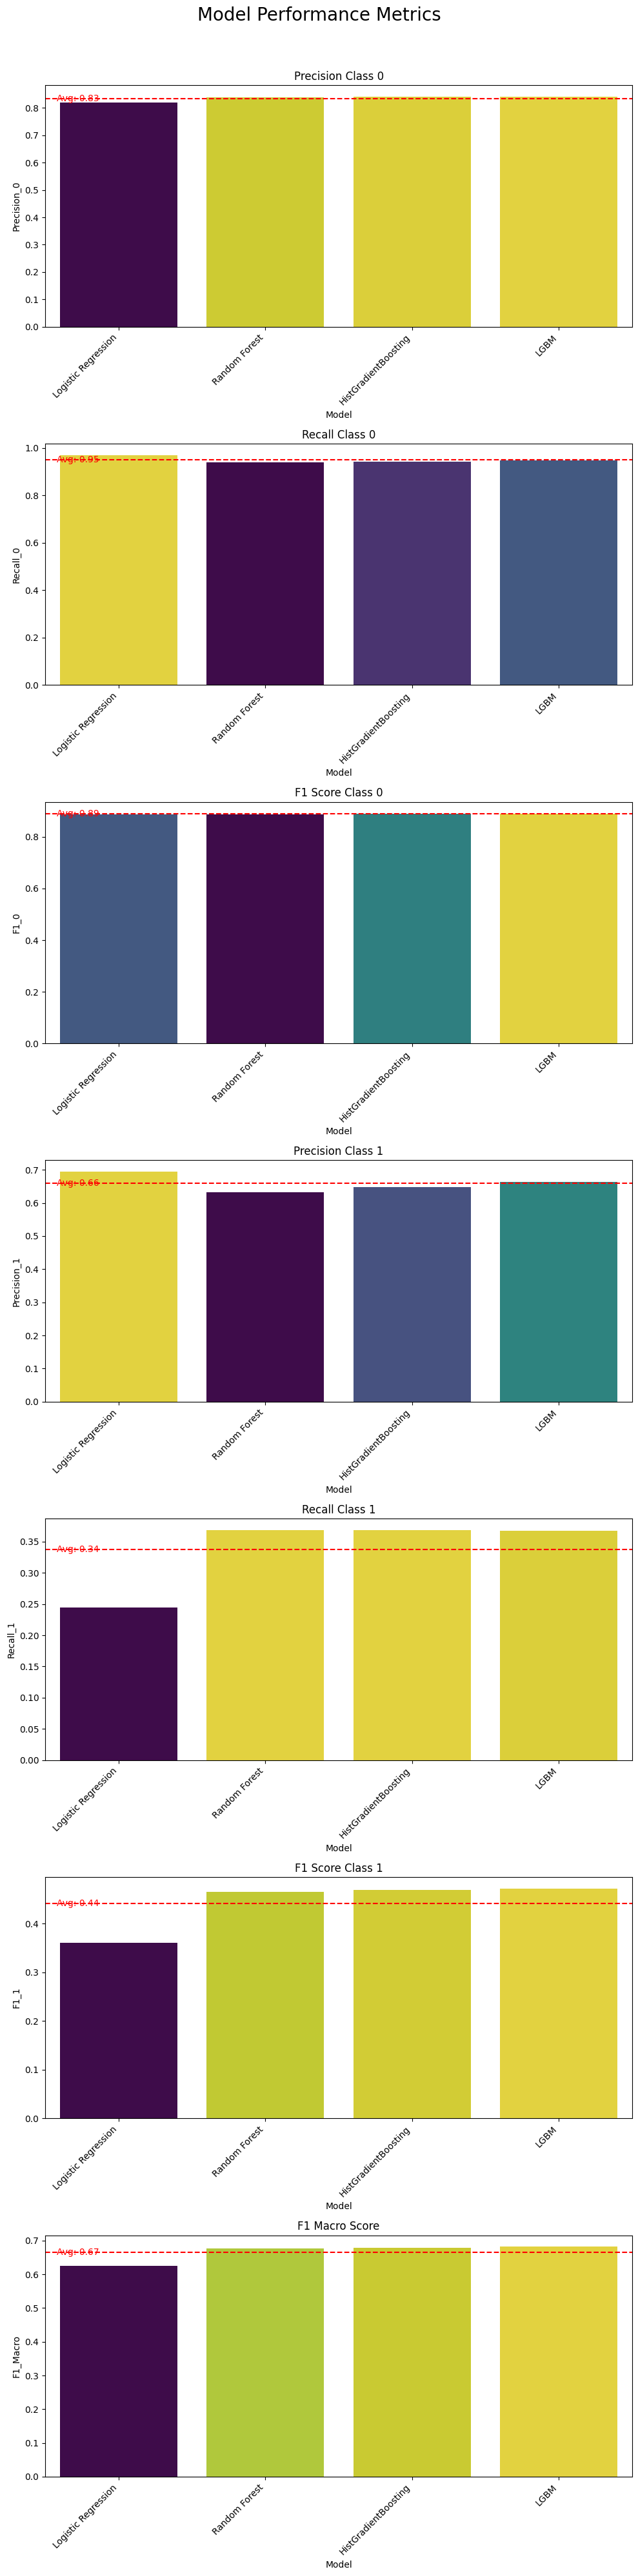

,Model,Model_Type,Recall_0,Precision_0,F1_0,Recall_1,Precision_1,F1_1,F1_Macro,Accuracy
0,Logistic Regression,baseline,0.969399,0.818724,0.887713,0.244160,0.693790,0.361204,0.624459,0.809000
1,Random Forest,RF,0.939225,0.839679,0.886667,0.368500,0.632600,0.465714,0.676190,0.813000
2,HistGradientBoosting,baseline,0.942863,0.840198,0.888575,0.368500,0.646825,0.469515,0.679045,0.815833
3,LGBM,baseline,0.947143,0.840486,0.890633,0.366993,0.663488,0.472586,0.681609,0.818833


In [8]:
# Plot the report
plot_report(metrics_df, palette='magma')
# Display the metrics DataFrame
metrics_df

#### Write Data Utils Script

In [7]:
script_content=r'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import joblib
import json
import logging
# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

#--------   Load and Preprocess Data   --------#

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

def rename_columns(df):
    rename_dict = {'pay_0': 'pay_1'}
    df = df.rename(columns=rename_dict)
    return df

def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

def split_features_target(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        df = clean_column_names(df)
        df = remove_id_column(df)
        df = rename_columns(df)
        df = convert_categorical(df, categorical_columns)
        X, y = split_features_target(df, target)
        return X, y
    return None, None


#--------   Evaluate and Capture Metrics   --------#

def evaluate_model(pipeline, X_train, X_test, y_train, y_test, model_name, model_type):
    logger.info(f"Training and evaluating model: {model_name} ({model_type})")

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Capture classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Extract relevant metrics
    metrics = {
        'Model': model_name,
        'Model_Type': model_type,
        'Recall_0': report['0']['recall'],
        'Precision_0': report['0']['precision'],
        'F1_0': report['0']['f1-score'],
        'Recall_1': report['1']['recall'],
        'Precision_1': report['1']['precision'],
        'F1_1': report['1']['f1-score'],
        'F1_Macro': report['macro avg']['f1-score'],
        'Accuracy': report['accuracy']
    }

    logger.info(f"Completed evaluation for model: {model_name} ({model_type})")
    return metrics

def compile_metrics(metrics_list, csv_filename='model_metrics.csv'):
    # Convert the list of metrics dictionaries to a DataFrame
    metrics_df = pd.DataFrame(metrics_list)

    # Save the metrics DataFrame to a CSV file
    metrics_df.to_csv(csv_filename, index=False)
    logger.info(f"Metrics saved to {csv_filename}")

    return metrics_df

def plot_report(metrics_df, palette='viridis'):
    # Generate a summary report using matplotlib or seaborn
    metrics_to_plot = ['Precision_0', 'Recall_0', 'F1_0', 'Precision_1', 'Recall_1', 'F1_1', 'F1_Macro']
    titles = ['Precision Class 0', 'Recall Class 0', 'F1 Score Class 0', 'Precision Class 1', 'Recall Class 1', 'F1 Score Class 1', 'F1 Macro Score']

    fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(10, len(metrics_to_plot) * 6))
    fig.suptitle('Model Performance Metrics', fontsize=20)

    for metric, title, ax in zip(metrics_to_plot, titles, axes):
        sns.barplot(x='Model', y=metric, hue=metric, data=metrics_df, palette='viridis', ax=ax, legend=False)
        ax.set_title(title)
        ax.set_ylabel(metric)
        ax.set_xlabel('Model')
        # ax.legend(title='Model Type')

        # Add average line for each metric
        mean_value = metrics_df[metric].mean()
        ax.axhline(mean_value, color='red', linestyle='--')
        ax.text(0.02, mean_value, f'Avg: {mean_value:.2f}', color='red', ha='left', va='center', transform=ax.get_yaxis_transform())

        # Correctly set tick labels
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.savefig('model_performance_metrics_report.png')
    plt.show()
    logger.info("Generated performance report")


'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *

Script successfully written to loan_data_utils.py
